In [25]:
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from norse.torch.functional.lif import LIFParameters

from cgtasknet.net.lifrefrac import SNNLifRefrac
from norse.torch.functional.lif_refrac import LIFRefracParameters

from cgtasknet.net.states import LIFRefracInitState
from cgtasknet.tasks.reduce import DefaultParams, DMTask
from tqdm import tqdm

In [27]:
feature_size = 2
output_size = 3
hidden_size = 400
batch_size = 1
neuron_parameters = LIFRefracParameters(
    LIFParameters(
        alpha=torch.as_tensor(100), method="super", v_th=torch.as_tensor(0.65)
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNLifRefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
)
if True:
    model.load_state_dict(
        torch.load("..\models\\only_dm_lif_refrac\\Only_dm_lif_refrac_net")
    )
number_of_tasks = 100

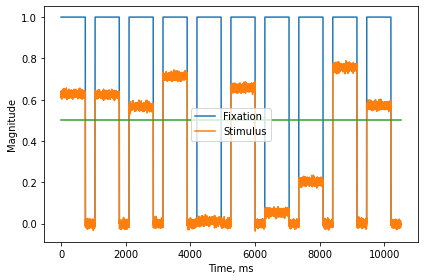

In [28]:
dmparams1 = DefaultParams("DMTask").generate_params()

task = DMTask(dmparams1, mode="random")
inputs, _ = task.dataset(10)
inputs[:, 0, 1:2] += np.random.normal(0, 0.01, size=(inputs.shape[0], 1))
plt.plot(inputs[:, 0, 0], label="Fixation")
plt.plot(inputs[:, 0, 1], label="Stimulus")
plt.plot([0, inputs.shape[0]], [0.5] * 2)
plt.xlabel("Time, ms")
plt.ylabel("Magnitude")
plt.legend()
plt.tight_layout()
plt.savefig("task.pdf")

In [29]:
inputs[:, 0, 1:3].shape

(10500, 1)

In [30]:
dt = 1e-3
subgroup_finder = SubgroupFinder(dt)
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in tqdm(range(number_of_tasks)):
    dmparams1 = DefaultParams("DMTask").generate_params()
    dmparams1["value"] = np.random.uniform(0, 0.5)
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out, states = model(inputs, first_state)
    s = []
    for j in range(len(states)):
        s.append(states[j].lif.z)
    s = torch.stack(s).detach()
    s = s.reshape((s.shape[0], s.shape[2]))
    subgroup_finder.compute_average_freq([s], [inputs[:, 0, 0]], [out], [t_outputs])

100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


In [31]:
dt = 1e-3
subgroup_finder2 = SubgroupFinder(dt)
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in tqdm(range(number_of_tasks)):
    dmparams1 = DefaultParams("DMTask").generate_params()
    dmparams1["value"] = np.random.uniform(0.51, 1)
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out, states = model(inputs, first_state)
    s = []
    for j in range(len(states)):
        s.append(states[j].lif.z)
    s = torch.stack(s).detach()
    s = s.reshape((s.shape[0], s.shape[2]))
    subgroup_finder2.compute_average_freq([s], [inputs[:, 0, 0]], [out], [t_outputs])

100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


In [32]:
for name, params in model.named_parameters():
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach())

In [33]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
strenght_first = answer_first * out_weights[1, :]
strenght_second = answer_second * out_weights[2, :]
strenght_first_freq_second_out = answer_first * out_weights[2, :]
strenght_second_freq_first_out = answer_second * out_weights[1, :]

strenght_first_freq_fixation = fixation_first * out_weights[1, :]
strenght_second_freq_fixation = fixation_second * out_weights[2, :]
strenght_first_freq_second_out_fixation = fixation_first * out_weights[2, :]
strenght_second_freq_first_out_fixation = fixation_second * out_weights[1, :]

strenght_first_sort = sort_elemnts_by_another(strenght_first, strenght_first)
strenght_second_sort = sort_elemnts_by_another(strenght_first, strenght_second)
strenght_first_freq_second_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out
)
strenght_second_freq_first_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out
)

strenght_first_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_fixation
)
strenght_second_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_fixation
)
strenght_first_freq_second_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out_fixation
)
strenght_second_freq_first_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out_fixation
)

In [34]:
def plot_hist(data, c="b", alpha=1):
    x = np.arange(0, len(data), 1)
    for i in range(len(data)):
        plt.plot([x[i]] * 2, [0, data[i]], c=c, alpha=alpha)

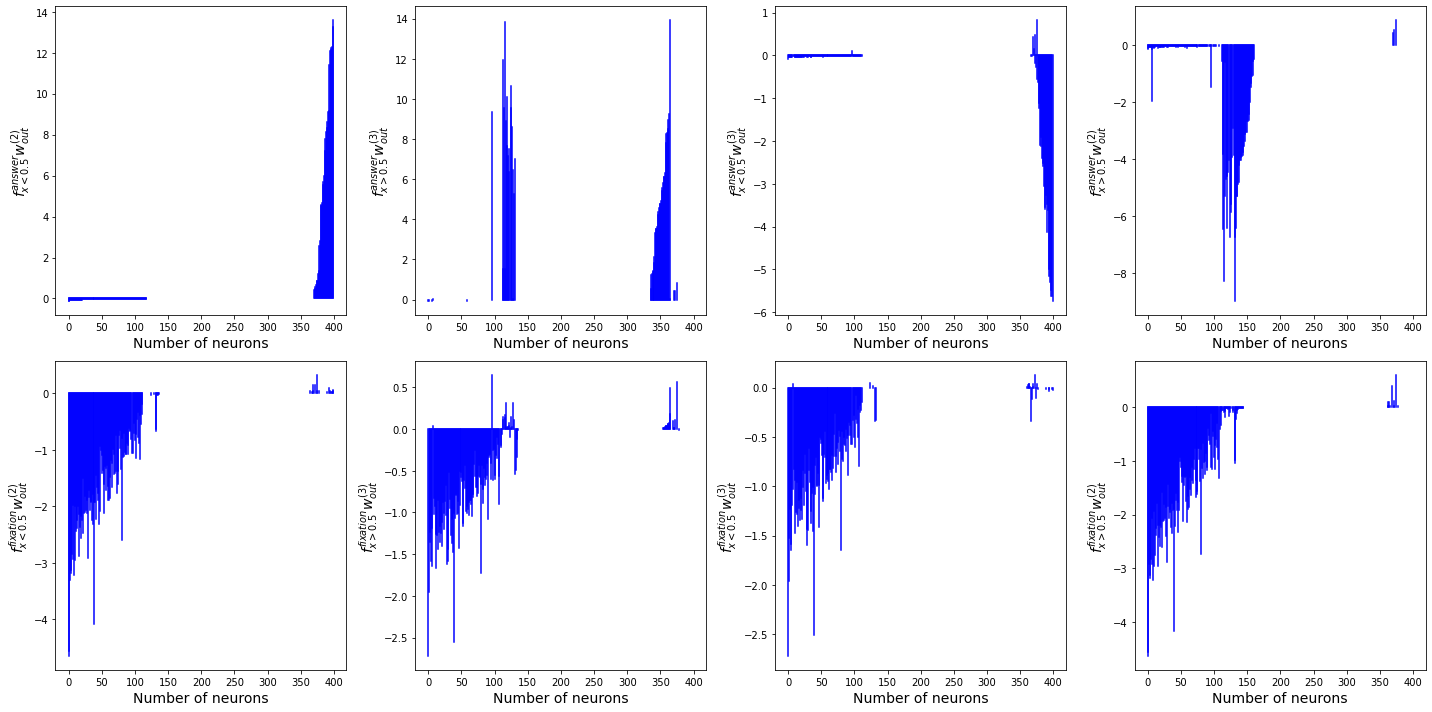

In [35]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))
plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_sort.numpy())

plt.subplot(243)
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_second_out_sort.numpy())

plt.subplot(244)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_first_out_sort.numpy())

plt.subplot(245)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_fixation_sort.numpy())

plt.subplot(246)
plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_fixation_sort.numpy())


plt.subplot(247)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_second_out_fixation_sort.numpy())

plt.subplot(248)

plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_first_out_fixation_sort.numpy())
plt.tight_layout()
# plt.savefig("freq_strenght.pdf")
plt.show()

In [36]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
# strenght_first = answer_first * out_weights[1, :]
fixation_first_sort = sort_elemnts_by_another(strenght_first, fixation_first)
fixation_second_sort = sort_elemnts_by_another(strenght_first, fixation_second)
answer_first_sort = sort_elemnts_by_another(strenght_first, answer_first)
answer_second_sort = sort_elemnts_by_another(strenght_first, answer_second)
out1_sort = sort_elemnts_by_another(strenght_first, out_weights[0, :])
out2_sort = sort_elemnts_by_another(strenght_first, out_weights[1, :])
out3_sort = sort_elemnts_by_another(strenght_first, out_weights[2, :])

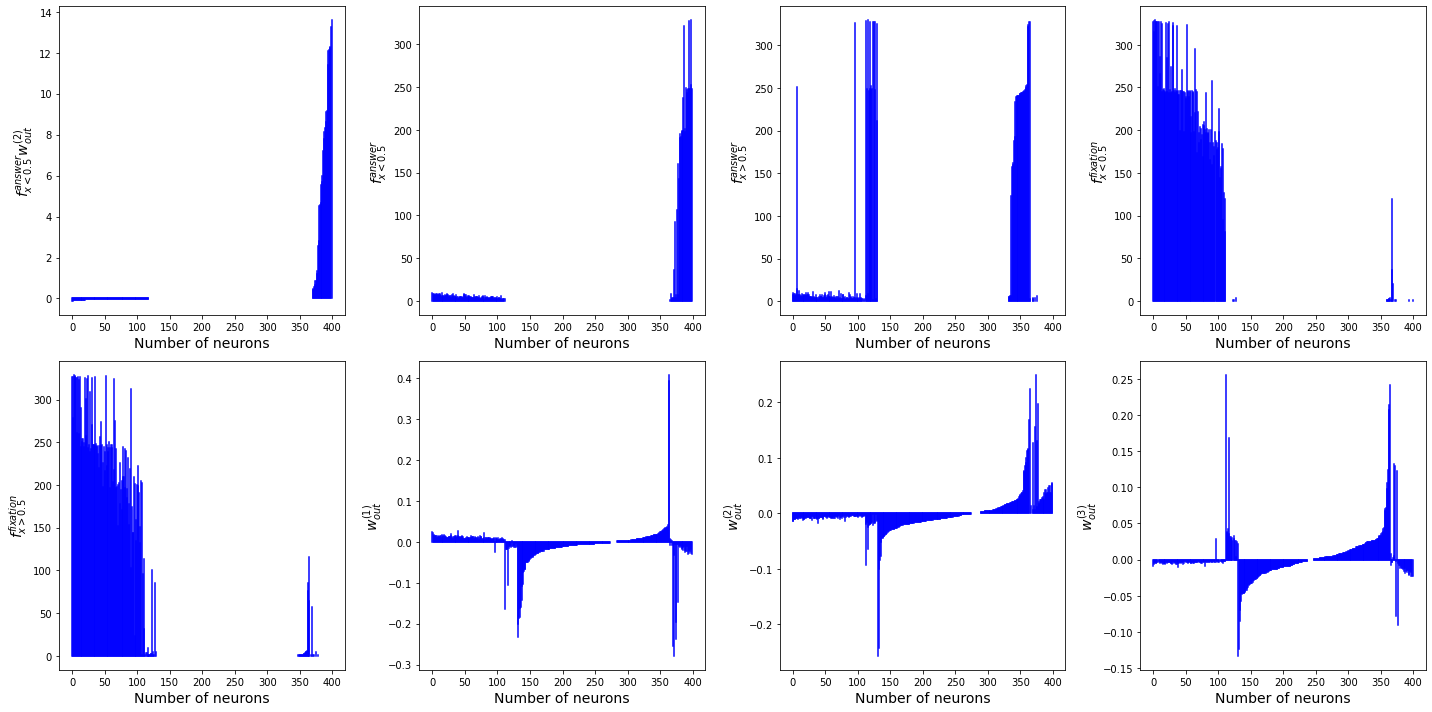

In [37]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))


plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plot_hist(answer_first_sort.numpy())


plt.ylabel(r"$f^{answer}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(243)
plot_hist(answer_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(244)
plot_hist(fixation_first_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(245)
plot_hist(fixation_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(246)
plot_hist(out1_sort.numpy())
plt.ylabel(r"${w_{out}^{(1)}}$")
plt.xlabel("Number of neurons")

plt.subplot(247)
plot_hist(out2_sort.numpy())
plt.ylabel(r"${w_{out}^{(2)}}$")
plt.xlabel("Number of neurons")


plt.subplot(248)
plot_hist(out3_sort.numpy())
plt.ylabel(r"${w_{out}^{(3)}}$")
plt.xlabel("Number of neurons")


plt.tight_layout()
# plt.savefig("freq.pdf")
plt.show()

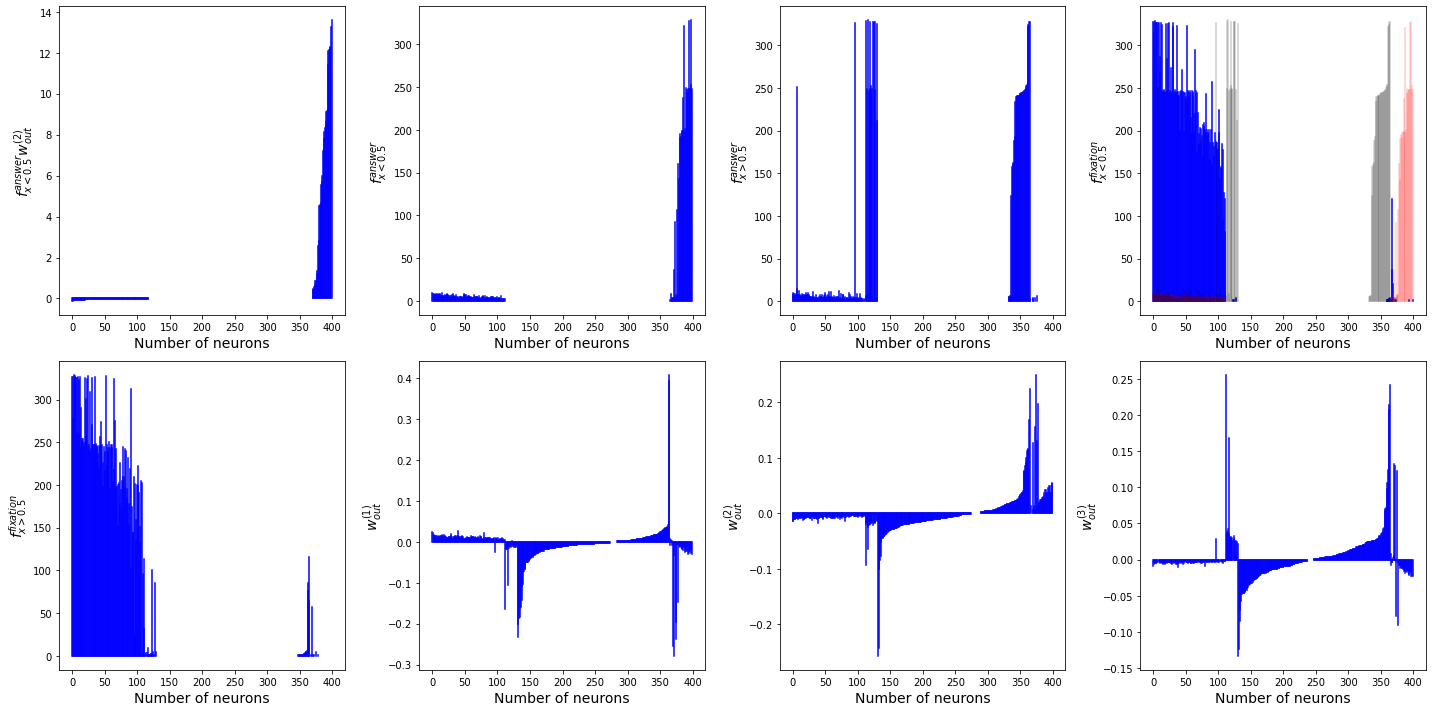

In [38]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))


plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plot_hist(answer_first_sort.numpy())


plt.ylabel(r"$f^{answer}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(243)
plot_hist(answer_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(244)
plot_hist(fixation_first_sort.numpy())
plot_hist(answer_first_sort.numpy(), c="r", alpha=0.2)
plot_hist(answer_second_sort.numpy(), c="black", alpha=0.2)

plt.ylabel(r"$f^{fixation}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(245)
plot_hist(fixation_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(246)
plot_hist(out1_sort.numpy())
plt.ylabel(r"${w_{out}^{(1)}}$")
plt.xlabel("Number of neurons")

plt.subplot(247)
plot_hist(out2_sort.numpy())
plt.ylabel(r"${w_{out}^{(2)}}$")
plt.xlabel("Number of neurons")


plt.subplot(248)
plot_hist(out3_sort.numpy())
plt.ylabel(r"${w_{out}^{(3)}}$")
plt.xlabel("Number of neurons")


plt.tight_layout()
# plt.savefig("freq.pdf")
plt.show()

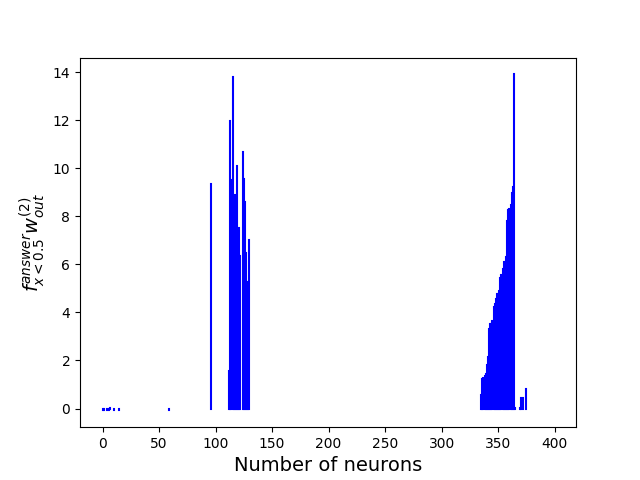

In [39]:
%matplotlib widget
plt.figure()
plot_hist(strenght_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.show()

In [40]:
for name, params in model.named_parameters():
    if name == "lif_refrac.recurrent_weights":
        rec_weights = torch.clone(params.detach())

list_numbers = [i for i in range(len(rec_weights))]

In [41]:
for name, params in model.named_parameters():
    if name == "lif_refrac.input_weights":
        input_weights = torch.clone(params.detach())

In [42]:
input_weights.shape

torch.Size([400, 2])

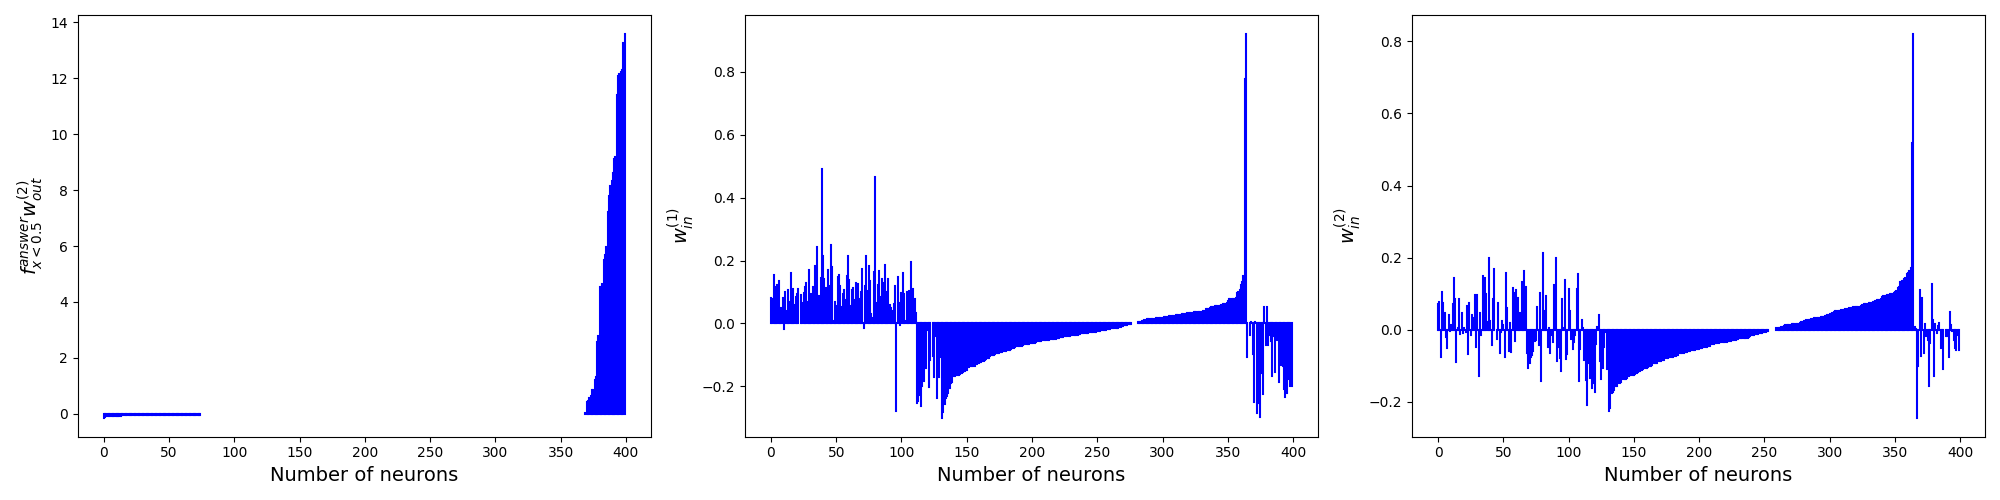

In [43]:
input_sort_1 = sort_elemnts_by_another(strenght_first, input_weights[:, 0])
input_sort_2 = sort_elemnts_by_another(strenght_first, input_weights[:, 1])

plt.figure(figsize=(20, 5))
plt.subplot(131)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.subplot(132)
plot_hist(input_sort_1.numpy())
plt.ylabel(r"$w_{in}^{(1)}$")
plt.xlabel("Number of neurons")
plt.subplot(133)
plot_hist(input_sort_2.numpy())
plt.ylabel(r"$w_{in}^{(2)}$")
plt.xlabel("Number of neurons")
plt.tight_layout()
# plt.savefig("w_in.pdf")
plt.show()

In [44]:
list_sum_out_weights = []


list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)

In [45]:
rec_weights_sort = torch.zeros_like(rec_weights)

for i in range(len(list_numbers)):
    rec_weights_sort[i] = rec_weights[list_numbers_sort[i]]

C:\Users\slava\AppData\Local\Temp/ipykernel_10876/503448429.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("rec_w.pdf", interpolation="None")


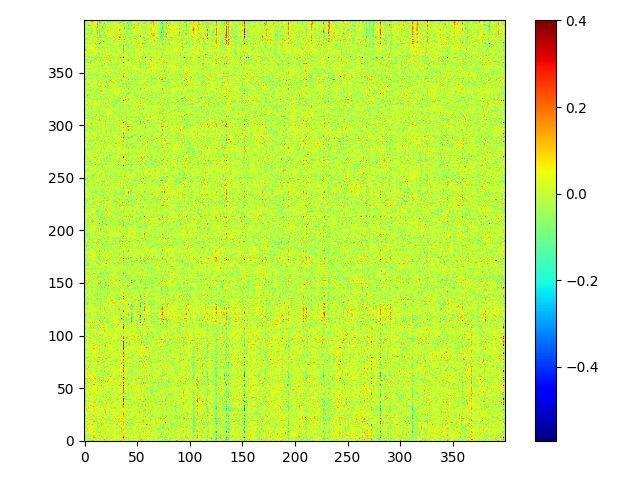

In [46]:
plt.figure()
plt.imshow(rec_weights_sort.numpy(), origin="lower", cmap="jet", vmax=0.4)
plt.colorbar()
plt.tight_layout()
plt.savefig("rec_w.pdf", interpolation="None")
plt.show()

# SELECTIVITY

In [18]:
dt = 1e-3

init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
values = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
Neurons_frequency_fixation = np.zeros((hidden_size, len(values)))
Neurons_frequency_answer = np.zeros((hidden_size, len(values)))
number_of_tasks = 100
for value_i in tqdm(range(len(values))):
    subgroup_finder_choose = SubgroupFinder(dt)
    for i in range(number_of_tasks):

        dmparams1 = DefaultParams("DMTask").generate_params()
        dmparams1["value"] = values[value_i]
        task = DMTask(dmparams1, mode="value")
        inputs, t_outputs = task.dataset(1)
        inputs = torch.from_numpy(inputs).type(torch.float32)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
        out, states = model(inputs, first_state)
        s = []
        for j in range(len(states)):
            s.append(states[j].lif.z)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        subgroup_finder_choose.compute_average_freq(
            [s], [inputs[:, 0, 0]], [out], [t_outputs]
        )
    Neurons_frequency_fixation[:, value_i] += (
        subgroup_finder_choose.get_average_freq()[0].cpu()
    ).numpy()
    Neurons_frequency_answer[:, value_i] += (
        subgroup_finder_choose.get_average_freq()[1].cpu()
    ).numpy()

100%|██████████| 10/10 [07:03<00:00, 42.32s/it]


In [19]:
Neurons_frequency_fixation_copy = torch.from_numpy(Neurons_frequency_fixation).type(
    torch.float
)
Neurons_frequency_answer_copy = torch.from_numpy(Neurons_frequency_answer).type(
    torch.float
)

In [20]:
Neurons_frequency_fixation_sort = torch.zeros_like(Neurons_frequency_fixation)

list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_fixation_sort[i] = Neurons_frequency_fixation[
        list_numbers_sort[i]
    ]


plt.imshow(Neurons_frequency_fixation_sort, aspect="auto", origin="lower")
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_fixation_sort_first.pdf")
plt.show()
plt.close()
Neurons_frequency_fixation_sort = torch.zeros_like(Neurons_frequency_fixation)

list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_second, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_fixation_sort[i] = Neurons_frequency_fixation[
        list_numbers_sort[i]
    ]


plt.imshow(Neurons_frequency_fixation_sort, aspect="auto", origin="lower")
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_fixation_sort_second.pdf")
plt.show()
plt.close()

TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

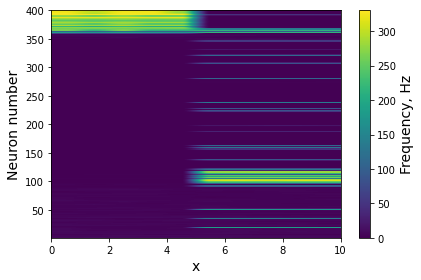

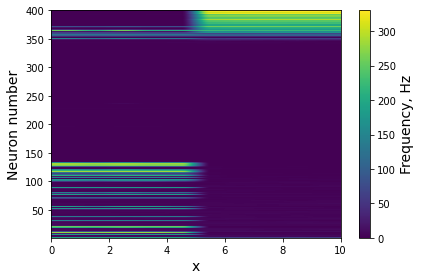

In [ ]:
# Neurons_frequency_answer = torch.from_numpy(Neurons_frequency_answer).type(torch.float)
Neurons_frequency_answer_sort = torch.zeros_like(Neurons_frequency_answer)
list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_answer_sort[i] = Neurons_frequency_answer[list_numbers_sort[i]]
plt.figure()
plt.imshow(
    Neurons_frequency_answer_sort, aspect="auto", origin="lower", extent=[0, 10, 1, 401]
)
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_answer_sort_first.pdf")
plt.show()
plt.close()

# Neurons_frequency_answer = torch.from_numpy(Neurons_frequency_answer).type(torch.float)
Neurons_frequency_answer_sort = torch.zeros_like(Neurons_frequency_answer)
list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_second, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_answer_sort[i] = Neurons_frequency_answer[list_numbers_sort[i]]
plt.figure()
plt.imshow(
    Neurons_frequency_answer_sort, aspect="auto", origin="lower", extent=[0, 10, 1, 401]
)
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_answer_sort_second.pdf")
plt.show()
plt.close()

In [ ]:
Neurons_frequency_answer_sort.shape

torch.Size([401, 10])

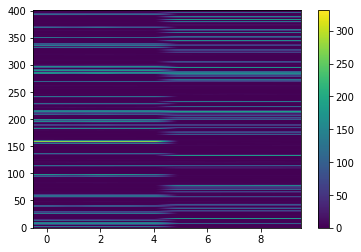

In [ ]:
plt.imshow(Neurons_frequency_answer, aspect="auto", origin="lower")
plt.colorbar()

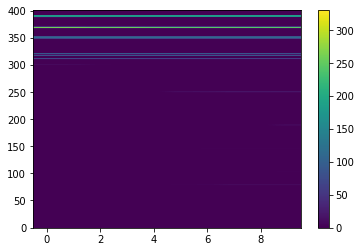

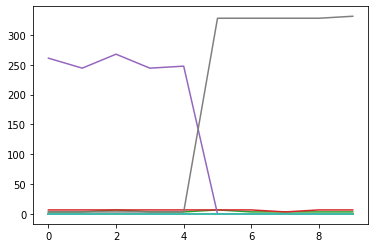

In [ ]:
for i in range(10, 20):
    plt.plot(Neurons_frequency_answer_copy[i, :])

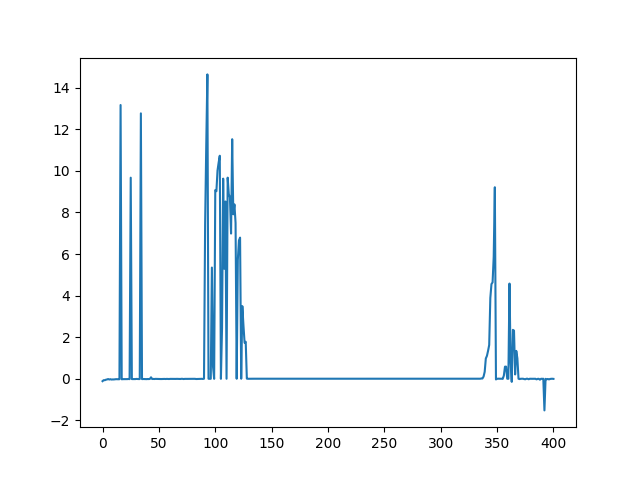

In [210]:
plt.figure()
plt.plot(strenght_second_sort.numpy())

In [53]:
rec_weights_sort
A_1_answer = [*torch.where(strenght_first_sort > 0)[0].type(torch.int).numpy()]
A_2_answer = [*torch.where(strenght_second_sort > 0)[0].type(torch.int).numpy()]

A_fix = [*torch.where(fixation_first > 0)[0].type(torch.int).numpy()]
################################################################A_1_answer = list(set(A_1_answer) - set(A_fix))
# A_2_answer = list(set(A_2_answer) - set(A_fix))
set_full_neurons = set([i for i in range(hidden_size)])
active_neurons = set((*A_1_answer, *A_2_answer, *A_fix))
usless_neurons = list(set_full_neurons - active_neurons)
len(usless_neurons)

201

In [54]:
input_1_to_fix = torch.mean(input_sort_1[A_fix])
input_2_to_fix = torch.mean(input_sort_2[A_fix])
input_1_to_1_answ = torch.mean(input_sort_1[A_1_answer])
input_2_to_1_answ = torch.mean(input_sort_2[A_1_answer])
input_1_to_2_answ = torch.mean(input_sort_1[A_2_answer])
input_2_to_2_answ = torch.mean(input_sort_2[A_2_answer])
input_1_to_usles = torch.mean(input_sort_1[usless_neurons])
input_2_to_usles = torch.mean(input_sort_2[usless_neurons])

answ_1_to_fix = torch.mean(rec_weights_sort[:, A_1_answer][A_fix, :])
answ_2_to_fix = torch.mean(rec_weights_sort[:, A_2_answer][A_fix, :])
fix_to_answ_1 = torch.mean(rec_weights_sort[:, A_fix][A_1_answer, :])
fix_to_answ_2 = torch.mean(rec_weights_sort[:, A_fix][A_2_answer, :])

answ_1_to_answ_2 = torch.mean(rec_weights_sort[:, A_1_answer][A_2_answer, :])
answ_2_to_answ_1 = torch.mean(rec_weights_sort[:, A_2_answer][A_1_answer, :])

fix_to_out_0 = torch.mean(out1_sort[A_fix])
fix_to_out_1 = torch.mean(out2_sort[A_fix])
fix_to_out_2 = torch.mean(out3_sort[A_fix])

answ_1_to_out0 = torch.mean(out1_sort[A_1_answer])
answ_2_to_out0 = torch.mean(out1_sort[A_2_answer])


answ_1_to_out1 = torch.mean(out2_sort[A_1_answer])
answ_1_to_out2 = torch.mean(out3_sort[A_1_answer])
answ_2_to_out1 = torch.mean(out2_sort[A_2_answer])
answ_2_to_out2 = torch.mean(out3_sort[A_2_answer])

fix_to_usless = torch.mean(rec_weights_sort[:, A_fix][usless_neurons, :])
answ_1_to_usless = torch.mean(rec_weights_sort[:, A_1_answer][usless_neurons, :])
answ_2_to_usless = torch.mean(rec_weights_sort[:, A_2_answer][usless_neurons, :])


usless_to_out_1 = torch.mean(out1_sort[usless_neurons])
usless_to_out_2 = torch.mean(out2_sort[usless_neurons])
usless_to_out_3 = torch.mean(out3_sort[usless_neurons])

usless_to_fix = torch.mean(rec_weights_sort[:, usless_neurons][A_fix, :])
usless_to_answ_1 = torch.mean(rec_weights_sort[:, usless_neurons][A_1_answer, :])
usless_to_answ_2 = torch.mean(rec_weights_sort[:, usless_neurons][A_2_answer, :])

fix_to_fix = torch.mean(rec_weights_sort[A_fix, :][:, A_fix])
answ_1_to_answ_1 = torch.mean(rec_weights_sort[:, A_1_answer][A_1_answer, :])
answ_2_to_answ_2 = torch.mean(rec_weights_sort[:, A_2_answer][A_2_answer, :])
usless_to_usless = torch.mean(rec_weights_sort[:, usless_neurons][usless_neurons, :])

print(f"in_1 -> fix: {input_1_to_fix}")
print(f"in_2 -> fix: {input_2_to_fix}")
print(f"in_1 -> first answ: {input_1_to_1_answ}")
print(f"in_2 -> first answ: {input_2_to_1_answ}")
print(f"in_1 -> second answ: {input_1_to_2_answ}")
print(f"in_2 -> second answ: {input_2_to_2_answ}")
print(f"in_1 -> usles: {input_1_to_usles}")
print(f"in_2 -> usles: {input_2_to_usles}")

print(f"fix -> answ 1: {fix_to_answ_1}")
print(f"fix -> answ 2: {fix_to_answ_2}")
print(f"fix -> usles 1: {fix_to_usless}")
print(f"answ_1 -> usles: {answ_1_to_usless}")
print(f"answ_2 -> usles: {answ_2_to_usless}")
print(f"answ 1 -> answ 2: {answ_1_to_answ_2}")
print(f"answ 2 -> answ 1: {answ_2_to_answ_1}")

print(f"usless -> fix: {usless_to_fix}")
print(f"usless -> answ 1: {usless_to_answ_1}")
print(f"usless -> answ 2: {usless_to_answ_2}")
print(f"fix -> out 1: {fix_to_out_0}")
print(f"fix -> out 2: {fix_to_out_1}")
print(f"fix -> out 3: {fix_to_out_2}")


print(f"answ 1 -> out 1: {answ_1_to_out0}")
print(f"answ 2 -> out 1: {answ_2_to_out0}")
print(f"answ 1 -> out 2: {answ_1_to_out1}")
print(f"answ 2 -> out 2: {answ_2_to_out1}")
print(f"answ 1 -> out 3: {answ_1_to_out2}")
print(f"answ 2 -> out 3: {answ_2_to_out2}")
print(f"usless -> out 1: {usless_to_out_1}")
print(f"usless -> out 2: {usless_to_out_2}")
print(f"usless -> out 3: {usless_to_out_3}")

print(f"fix -> fix: {fix_to_fix}")
print(f"answ 1 -> answ 1: {answ_1_to_answ_1}")
print(f"answ 2 -> answ 2: {answ_2_to_answ_2}")
print(f"usless -> usless: {usless_to_usless}")

in_1 -> fix: 0.004443222191184759
in_2 -> fix: 0.0032515055499970913
in_1 -> first answ: -0.11917755752801895
in_2 -> first answ: -0.02631397545337677
in_1 -> second answ: -0.007517585996538401
in_2 -> second answ: 0.04548021778464317
in_1 -> usles: -0.00010113429016200826
in_2 -> usles: -0.013998054899275303
fix -> answ 1: 0.010486364364624023
fix -> answ 2: -0.0038879571948200464
fix -> usles 1: -0.004413317888975143
answ_1 -> usles: -0.0023901620879769325
answ_2 -> usles: -0.0042182342149317265
answ 1 -> answ 2: -0.004160750657320023
answ 2 -> answ 1: 0.004946616943925619
usless -> fix: -0.003115170169621706
usless -> answ 1: -0.0022833803668618202
usless -> answ 2: 0.0014229801017791033
fix -> out 1: -0.004150094464421272
fix -> out 2: 0.0029280907474458218
fix -> out 3: 0.0006736357463523746
answ 1 -> out 1: -0.04409701004624367
answ 2 -> out 1: 0.0035464498214423656
answ 1 -> out 2: 0.048023682087659836
answ 2 -> out 2: 0.030362796038389206
answ 1 -> out 3: -0.003490905277431011


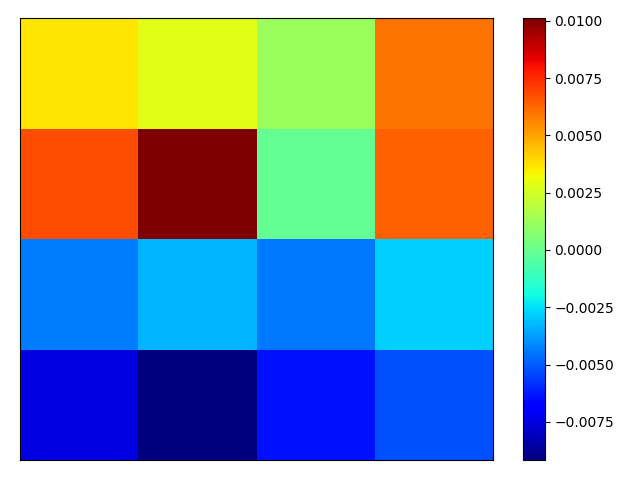

In [226]:
Matrix_blocks = np.zeros((4, 4))
Matrix_blocks[0, 0] = usless_to_usless
Matrix_blocks[1, 1] = fix_to_fix
Matrix_blocks[2, 2] = answ_1_to_answ_1
Matrix_blocks[3, 3] = answ_2_to_answ_2

Matrix_blocks[0, 1] = usless_to_fix
Matrix_blocks[0, 2] = usless_to_answ_1
Matrix_blocks[0, 3] = usless_to_answ_2

Matrix_blocks[1, 0] = fix_to_usless
Matrix_blocks[1, 2] = fix_to_answ_1
Matrix_blocks[1, 3] = fix_to_answ_2

Matrix_blocks[2, 0] = answ_1_to_usless
Matrix_blocks[2, 1] = answ_1_to_fix
Matrix_blocks[2, 3] = answ_1_to_answ_2
Matrix_blocks[3, 0] = answ_2_to_usless
Matrix_blocks[3, 1] = answ_2_to_fix
Matrix_blocks[3, 2] = answ_2_to_answ_1

plt.figure()
plt.imshow(
    Matrix_blocks.T, aspect="auto", origin="lower", interpolation="nearest", cmap="jet"
)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.savefig("blocks.pdf")

plt.show()

In [214]:
input_1_to_fix = torch.sum(input_sort_1[A_fix])
input_2_to_fix = torch.sum(input_sort_2[A_fix])
input_1_to_1_answ = torch.sum(input_sort_1[A_1_answer])
input_2_to_1_answ = torch.sum(input_sort_2[A_1_answer])
input_1_to_2_answ = torch.sum(input_sort_1[A_2_answer])
input_2_to_2_answ = torch.sum(input_sort_2[A_2_answer])
input_1_to_usles = torch.sum(input_sort_1[usless_neurons])
input_2_to_usles = torch.sum(input_sort_2[usless_neurons])

answ_1_to_fix = torch.sum(rec_weights_sort[:, A_1_answer][A_fix, :])
answ_2_to_fix = torch.sum(rec_weights_sort[:, A_2_answer][A_fix, :])
fix_to_answ_1 = torch.sum(rec_weights_sort[:, A_fix][A_1_answer, :])
fix_to_answ_2 = torch.sum(rec_weights_sort[:, A_fix][A_2_answer, :])

answ_1_to_answ_2 = torch.sum(rec_weights_sort[:, A_1_answer][A_2_answer, :])
answ_2_to_answ_1 = torch.sum(rec_weights_sort[:, A_2_answer][A_1_answer, :])

fix_to_out_0 = torch.sum(out1_sort[A_fix])
fix_to_out_1 = torch.sum(out2_sort[A_fix])
fix_to_out_2 = torch.sum(out3_sort[A_fix])

answ_1_to_out0 = torch.sum(out1_sort[A_1_answer])
answ_2_to_out0 = torch.sum(out1_sort[A_2_answer])


answ_1_to_out1 = torch.sum(out2_sort[A_1_answer])
answ_1_to_out2 = torch.sum(out3_sort[A_1_answer])
answ_2_to_out1 = torch.sum(out2_sort[A_2_answer])
answ_2_to_out2 = torch.sum(out3_sort[A_2_answer])

fix_to_usless = torch.sum(rec_weights_sort[:, A_fix][usless_neurons, :])
answ_1_to_usless = torch.sum(rec_weights_sort[:, A_1_answer][usless_neurons, :])
answ_2_to_usless = torch.sum(rec_weights_sort[:, A_2_answer][usless_neurons, :])


usless_to_out_1 = torch.sum(out1_sort[usless_neurons])
usless_to_out_2 = torch.sum(out2_sort[usless_neurons])
usless_to_out_3 = torch.sum(out3_sort[usless_neurons])

usless_to_fix = torch.sum(rec_weights_sort[:, usless_neurons][A_fix, :])
usless_to_answ_1 = torch.sum(rec_weights_sort[:, usless_neurons][A_1_answer, :])
usless_to_answ_2 = torch.sum(rec_weights_sort[:, usless_neurons][A_2_answer, :])

fix_to_fix = torch.sum(rec_weights_sort[A_fix, :][:, A_fix])
answ_1_to_answ_1 = torch.sum(rec_weights_sort[:, A_1_answer][A_1_answer, :])
answ_2_to_answ_2 = torch.sum(rec_weights_sort[:, A_2_answer][A_2_answer, :])
usless_to_usless = torch.sum(rec_weights_sort[:, usless_neurons][usless_neurons, :])

print(f"in_1 -> fix: {input_1_to_fix}")
print(f"in_2 -> fix: {input_2_to_fix}")
print(f"in_1 -> first answ: {input_1_to_1_answ}")
print(f"in_2 -> first answ: {input_2_to_1_answ}")
print(f"in_1 -> second answ: {input_1_to_2_answ}")
print(f"in_2 -> second answ: {input_2_to_2_answ}")
print(f"in_1 -> usles: {input_1_to_usles}")
print(f"in_2 -> usles: {input_2_to_usles}")

print(f"fix -> answ 1: {fix_to_answ_1}")
print(f"fix -> answ 2: {fix_to_answ_2}")
print(f"fix -> usles 1: {fix_to_usless}")
print(f"answ_1 -> usles: {answ_1_to_usless}")
print(f"answ_2 -> usles: {answ_2_to_usless}")
print(f"answ 1 -> answ 2: {answ_1_to_answ_2}")
print(f"answ 2 -> answ 1: {answ_2_to_answ_1}")

print(f"usless -> fix: {usless_to_fix}")
print(f"usless -> answ 1: {usless_to_answ_1}")
print(f"usless -> answ 2: {usless_to_answ_2}")
print(f"fix -> out 1: {fix_to_out_0}")
print(f"fix -> out 2: {fix_to_out_1}")
print(f"fix -> out 3: {fix_to_out_2}")


print(f"answ 1 -> out 1: {answ_1_to_out0}")
print(f"answ 2 -> out 1: {answ_2_to_out0}")
print(f"answ 1 -> out 2: {answ_1_to_out1}")
print(f"answ 2 -> out 2: {answ_2_to_out1}")
print(f"answ 1 -> out 3: {answ_1_to_out2}")
print(f"answ 2 -> out 3: {answ_2_to_out2}")
print(f"usless -> out 1: {usless_to_out_1}")
print(f"usless -> out 2: {usless_to_out_2}")
print(f"usless -> out 3: {usless_to_out_3}")

print(f"fix -> fix: {fix_to_fix}")
print(f"answ 1 -> answ 1: {answ_1_to_answ_1}")
print(f"answ 2 -> answ 2: {answ_2_to_answ_2}")
print(f"usless -> usless: {usless_to_usless}")

in_1 -> fix: 0.37610992789268494
in_2 -> fix: 1.2443981170654297
in_1 -> first answ: -1.7164757251739502
in_2 -> first answ: -0.3240141272544861
in_1 -> second answ: 0.9119077324867249
in_2 -> second answ: 1.9910742044448853
in_1 -> usles: -6.241381645202637
in_2 -> usles: -4.258179664611816
fix -> answ 1: 162.7293243408203
fix -> answ 2: 120.74356079101562
fix -> usles 1: -314.28460693359375
answ_1 -> usles: -112.48027801513672
answ_2 -> usles: -117.3102798461914
answ 1 -> answ 2: -13.577239990234375
answ 2 -> answ 1: 0.43895483016967773
usless -> fix: -71.47816467285156
usless -> answ 1: 2.41858172416687
usless -> answ 2: -15.235071182250977
fix -> out 1: -1.2885984182357788
fix -> out 2: 0.5837251543998718
fix -> out 3: 0.7029078602790833
answ 1 -> out 1: -0.6593307256698608
answ 2 -> out 1: 0.3881447911262512
answ 1 -> out 2: 1.0190449953079224
answ 2 -> out 2: 1.779211163520813
answ 1 -> out 3: 0.4267610013484955
answ 2 -> out 3: 1.6278882026672363
usless -> out 1: -4.022779464721

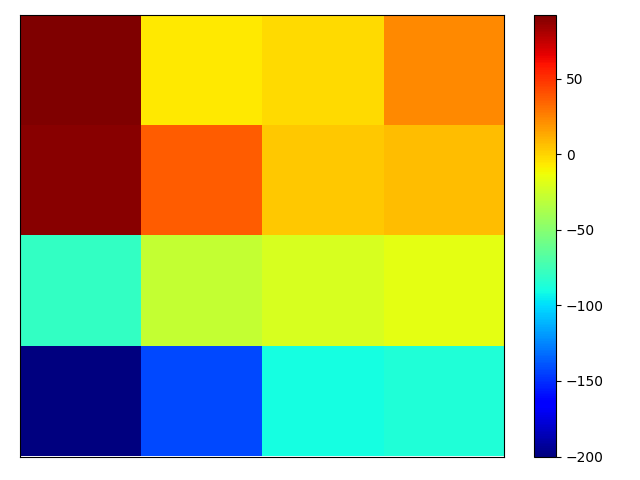

In [201]:
Matrix_blocks = np.zeros((4, 4))
Matrix_blocks[0, 0] = usless_to_usless
Matrix_blocks[1, 1] = fix_to_fix
Matrix_blocks[2, 2] = answ_1_to_answ_1
Matrix_blocks[3, 3] = answ_2_to_answ_2

Matrix_blocks[0, 1] = usless_to_fix
Matrix_blocks[0, 2] = usless_to_answ_1
Matrix_blocks[0, 3] = usless_to_answ_2

Matrix_blocks[1, 0] = fix_to_usless
Matrix_blocks[1, 2] = fix_to_answ_1
Matrix_blocks[1, 3] = fix_to_answ_2

Matrix_blocks[2, 0] = answ_1_to_usless
Matrix_blocks[2, 1] = answ_1_to_fix
Matrix_blocks[2, 3] = answ_1_to_answ_2
Matrix_blocks[3, 0] = answ_2_to_usless
Matrix_blocks[3, 1] = answ_2_to_fix
Matrix_blocks[3, 2] = answ_2_to_answ_1

plt.figure()
plt.imshow(
    Matrix_blocks.T,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    cmap="jet",
    vmin=-200,
)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.savefig("blocks.pdf")

plt.show()

In [64]:
rec_weights_sort[A_fix, :][:, A_1_answer]

tensor([[ 0.0770, -0.0246, -0.0348,  ..., -0.0021,  0.1356, -0.0090],
        [-0.0263,  0.0502,  0.0964,  ...,  0.1729,  0.1409, -0.0542],
        [-0.1964,  0.0474, -0.0186,  ...,  0.0247,  0.0156, -0.0760],
        ...,
        [-0.0923, -0.0199,  0.0407,  ...,  0.0000, -0.0594, -0.0625],
        [-0.1891, -0.1017,  0.0157,  ...,  0.0857,  0.0000, -0.0092],
        [ 0.1614,  0.0748,  0.0047,  ..., -0.0162, -0.1186, -0.0360]])

In [38]:
rec_weights_sort[A_fix, :].shape

torch.Size([130, 401])